In [1]:
import warnings
warnings.filterwarnings('ignore')

### Find Cointegrated Pairs

In [2]:
import pandas as pd
from openbb import obb
obb.user.preferences.output_type = "dataframe"

Function for downloading historical data using openbb

In [3]:
from __future__ import annotations
import pandas as pd
import logging
from pandas.errors import EmptyDataError
from typing import Iterable, List, Tuple, Union, Optional

def download_history_openbb(
    tickers: Union[Iterable[str], pd.Series, pd.Index],
    start_date: Union[str, pd.Timestamp],
    end_date:   Union[str, pd.Timestamp],
    *,
    provider: str = "yfinance",
    show_progress: bool = True,
    silence_logs: bool = True,
    return_failed: bool = False,
):
    """
    Download historical OHLCV for multiple tickers via OpenBB and stitch into one DataFrame.

    Returns:
        df                      (pd.DataFrame): concatenated results with MultiIndex (ticker, datetime).
        (optionally) failed     (List[str])   : tickers that returned no data or errored.
    """
    from tqdm import tqdm
    try:
        from openbb import obb  # OpenBB v4
    except Exception as e:
        raise ImportError("OpenBB not available. `pip install openbb` (v4).") from e

    # Silence noisy logs if requested
    if silence_logs:
        for lg in ["openbb_core", "openbb_yfinance", "openbb", "yfinance"]:
            logging.getLogger(lg).setLevel(logging.CRITICAL)

    # Clean ticker list
    tickers = (
        pd.Index(pd.Series(list(tickers), dtype="object"))
        .dropna()
        .astype(str)
        .unique()
        .tolist()
    )

    frames: List[Tuple[str, pd.DataFrame]] = []
    failed: List[str] = []

    iterator = tqdm(tickers, desc="Download", disable=not show_progress)
    for tkr in iterator:
        if show_progress:
            iterator.set_description(tkr)
        try:
            df_new = obb.equity.price.historical(
                symbol=tkr,
                start_date=start_date,
                end_date=end_date,
                provider=provider,
            )
            if df_new is None or len(df_new) == 0:
                failed.append(tkr)
                continue

            # Ensure datetime-like index and name it consistently
            df_new = df_new.copy()
            if not isinstance(df_new.index, pd.DatetimeIndex):
                df_new.index = pd.to_datetime(df_new.index, errors="coerce")
            # Some providers name it 'date' — normalize to 'datetime'
            dt_name = df_new.index.name or "datetime"
            df_new.index = df_new.index.rename("datetime")

            frames.append((tkr, df_new))
        except (EmptyDataError, Exception):
            failed.append(tkr)

    if frames:
        # Concatenate using keys to form MultiIndex with ticker first, datetime second
        keys = [k for k, _ in frames]
        objs = [df for _, df in frames]
        df = pd.concat(objs, keys=keys, names=["ticker", "datetime"])
        # (Optional) sort by ticker then time
        df = df.sort_index(level=["ticker", "datetime"])
    else:
        # Return an empty frame with the correct MultiIndex shape and common OHLCV columns
        empty_index = pd.MultiIndex.from_arrays([[], []], names=["ticker", "datetime"])
        df = pd.DataFrame(index=empty_index, columns=["open", "high", "low", "close", "adj_close", "volume"])

    if return_failed:
        return df, failed
    return df


Function for importing historical data from parquet lakes

In [4]:
from __future__ import annotations
from pathlib import Path
from typing import Iterable, List, Optional, Dict
import pandas as pd
import datetime as dt
from tqdm import tqdm

def _month_range(start: dt.date, end: dt.date) -> List[tuple[int,int]]:
    y, m = start.year, start.month
    out = []
    while (y < end.year) or (y == end.year and m <= end.month):
        out.append((y, m))
        if m == 12: y, m = y + 1, 1
        else: m += 1
    return out

def load_polygonio_lake(
    tickers: Iterable[str],
    start_date: str | dt.date | dt.datetime,
    end_date: str | dt.date | dt.datetime,
    root: str | Path,
    *,
    columns: Optional[List[str]] = None,
    source_tz: str = "US/Eastern",
    to_timezone: Optional[str] = None,
    set_index: bool = False,
    index_multi: bool = False,
    debug: bool = False
) -> pd.DataFrame:
    """
    Load <root>/<ticker>/<YYYY>/<MM>.parquet into one DataFrame filtered to [start_date, end_date].
    Shows a progress bar if debug=False.
    """
    # --- parse bounds ---
    s = pd.to_datetime(start_date)
    e = pd.to_datetime(end_date)
    if isinstance(start_date, (dt.date, str)) and not isinstance(start_date, dt.datetime):
        s = s.normalize()
    if isinstance(end_date, (dt.date, str)) and not isinstance(end_date, dt.datetime):
        e = (e.normalize() + pd.Timedelta(days=1)) - pd.Timedelta(nanoseconds=1)

    # --- columns: force include datetime & ticker ---
    read_cols = None
    if columns is not None:
        need = {"datetime", "ticker"}
        read_cols = list(dict.fromkeys(list(columns) + list(need)))

    # --- enumerate files ---
    root = Path(root)
    months = _month_range(s.date(), e.date())
    files: List[Path] = []
    for t in tickers:
        for (yy, mm) in months:
            f = root / t / f"{yy:04d}" / f"{mm:02d}.parquet"
            if f.exists():
                files.append(f)

    if not files:
        if debug:
            print(f"[DEBUG] No files found for {tickers} in {s.date()}..{e.date()}")
        return pd.DataFrame(columns=read_cols or ["datetime","ticker"])

    # --- read files with progress bar ---
    dfs = []
    iterator = files if debug else tqdm(files, desc="Loading Parquet", unit="file")
    for f in iterator:
        df_part = pd.read_parquet(f, columns=read_cols)
        dfs.append(df_part)

    df = pd.concat(dfs, ignore_index=True)

    # --- timezone handling ---
    if "datetime" not in df.columns:
        raise KeyError("Expected 'datetime' column in parquet files.")
    if not pd.api.types.is_datetime64tz_dtype(df["datetime"].dtype):
        df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
        df["datetime"] = df["datetime"].dt.tz_localize(source_tz, nonexistent="shift_forward", ambiguous="NaT")
    if to_timezone:
        df["datetime"] = df["datetime"].dt.tz_convert(to_timezone)

    # --- filter by date ---
    tz = df["datetime"].dt.tz
    s_bound = s if s.tzinfo else s.tz_localize(tz)
    e_bound = e if e.tzinfo else e.tz_localize(tz)
    df = df[(df["datetime"] >= s_bound) & (df["datetime"] <= e_bound)]

    # --- filter tickers ---
    if "ticker" in df.columns:
        df = df[df["ticker"].isin(set(tickers))]

    # --- sort + index ---
    sort_cols = ["ticker","datetime"] if "ticker" in df.columns else ["datetime"]
    df = df.sort_values(sort_cols)
    if set_index:
        if index_multi and "ticker" in df.columns:
            df = df.set_index(["ticker","datetime"]).sort_index()
        else:
            df = df.set_index("datetime").sort_index()

    return df


In [5]:
# tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

import json

# 1. Open the file
with open("ticker_lists/ndx.json", "r", encoding="utf-8") as f:
    # 2. Parse the JSON
    tickers = json.load(f)      # <-- data is now a Python object
tickers.sort()

In [6]:
start_date="2020-01-01"
end_date="2025-01-01"

df, failed = download_history_openbb(tickers, start_date, end_date, return_failed=True)

print(df.head())
if failed:
    print("No data for:", failed)

ZS: 100%|██████████| 101/101 [00:28<00:00,  3.53it/s]  

                        open       high        low      close     volume  \
ticker datetime                                                            
AAPL   2020-01-02  74.059998  75.150002  73.797501  75.087502  135480400   
       2020-01-03  74.287498  75.144997  74.125000  74.357498  146322800   
       2020-01-06  73.447502  74.989998  73.187500  74.949997  118387200   
       2020-01-07  74.959999  75.224998  74.370003  74.597504  108872000   
       2020-01-08  74.290001  76.110001  74.290001  75.797501  132079200   

                   split_ratio  dividend  
ticker datetime                           
AAPL   2020-01-02          0.0       0.0  
       2020-01-03          0.0       0.0  
       2020-01-06          0.0       0.0  
       2020-01-07          0.0       0.0  
       2020-01-08          0.0       0.0  


In [7]:
"""
start_date = "2020-01-01"
end_date   = "2025-01-01"
path_polygonio_data = "/home/mengren/data/polygonio_data/parquet_lake/day_aggs_v1/spx_ndx"

df = load_polygonio_lake(
    tickers,
    start_date,
    end_date,
    path_polygonio_data,
    columns=["datetime","ticker","open","high","low","close","volume"],
    to_timezone="UTC",
    set_index=True, index_multi=True,
    debug=False
)
print(df.shape)
"""

'\nstart_date = "2020-01-01"\nend_date   = "2025-01-01"\npath_polygonio_data = "/home/mengren/data/polygonio_data/parquet_lake/day_aggs_v1/spx_ndx"\n\ndf = load_polygonio_lake(\n    tickers,\n    start_date,\n    end_date,\n    path_polygonio_data,\n    columns=["datetime","ticker","open","high","low","close","volume"],\n    to_timezone="UTC",\n    set_index=True, index_multi=True,\n    debug=False\n)\nprint(df.shape)\n'

In [8]:
df

open        high         low       close     volume  \
ticker datetime                                                                
AAPL   2020-01-02   74.059998   75.150002   73.797501   75.087502  135480400   
       2020-01-03   74.287498   75.144997   74.125000   74.357498  146322800   
       2020-01-06   73.447502   74.989998   73.187500   74.949997  118387200   
       2020-01-07   74.959999   75.224998   74.370003   74.597504  108872000   
       2020-01-08   74.290001   76.110001   74.290001   75.797501  132079200   
...                       ...         ...         ...         ...        ...   
ZS     2024-12-24  185.979996  187.589996  184.679993  187.259995     654200   
       2024-12-26  186.000000  188.500000  185.869995  187.630005     806500   
       2024-12-27  185.259995  185.929993  181.259995  184.559998    1256100   
       2024-12-30  181.529999  184.404999  180.100006  183.130005    1032400   
       2024-12-31  184.115005  184.199997  179.723007  180.410004     920800   

                   split_ratio  dividend  
ticker datetime                           
AAPL   2020-01-02          0.0       0.0  
       2020-01-03          0.0       0.0  
       2020-01-06          0.0       0.0  
       2020-01-07          0.0       0.0  
       2020-01-08          0.0       0.0  
...                        ...       ...  
ZS     2024-12-24          NaN       NaN  
       2024-12-26          NaN       NaN  
       2024-12-27          NaN       NaN  
       2024-12-30          NaN       NaN  
       2024-12-31          NaN       NaN  

[123420 rows x 7 columns]

In [9]:
df.index.names

FrozenList(['ticker', 'datetime'])

In [10]:
df.index.get_level_values('datetime').min(), df.index.get_level_values('datetime').max()

(Timestamp('2020-01-02 00:00:00'), Timestamp('2024-12-31 00:00:00'))

### Pre-filter for Liquidity & Data Quality

In [11]:
import pandas as pd

# infer level names/positions
lvl_names = list(df.index.names)
ticker_lvl = 0                                  # you said ticker is first level
time_lvl_name = 'datetime' if 'datetime' in lvl_names else lvl_names[1]

# global time span
full_start = df.index.get_level_values(time_lvl_name).min()
full_end   = df.index.get_level_values(time_lvl_name).max()

# per-ticker start/end
starts = df.groupby(level=ticker_lvl).apply(
    lambda g: g.index.get_level_values(time_lvl_name).min()
)
ends = df.groupby(level=ticker_lvl).apply(
    lambda g: g.index.get_level_values(time_lvl_name).max()
)

# tickers whose coverage matches the global coverage
tickers_to_keep = starts[(starts == full_start) & (ends == full_end)].index

# filter df by those tickers
df_filtered = df.loc[pd.IndexSlice[tickers_to_keep, :]]


In [12]:
len(df.index.get_level_values('ticker').unique()), len(df_filtered.index.get_level_values('ticker').unique())

(101, 93)

In [13]:
set(tickers) - set(df_filtered.index.get_level_values('ticker').unique())

{'ABNB', 'APP', 'ARM', 'CEG', 'DASH', 'GEHC', 'GFS', 'PLTR'}

In [14]:
df = df_filtered

### Initial Cointegration Screening
 - Engle-Granger test, or
 - Johansen test

In [15]:
# ===================== FAST COINTEGRATION SCAN (Executor + initializer, no lambdas) =====================
from typing import Literal, Optional, Tuple, List
from concurrent.futures import ProcessPoolExecutor
from itertools import combinations
from functools import partial
import os, numpy as np, pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from threadpoolctl import threadpool_limits
from tqdm import tqdm

# ---- worker globals (populated by _init_worker) ----
_SERIES_MAP = None
_KEYS = None
_FULL_START = None
_FULL_END = None

def _init_worker(series_map, keys, full_start, full_end):
    """Runs once per worker process. Store heavy objects in globals and cap BLAS threads."""
    global _SERIES_MAP, _KEYS, _FULL_START, _FULL_END
    _SERIES_MAP = series_map
    _KEYS = keys
    _FULL_START = full_start
    _FULL_END = full_end

    # Cap BLAS threads inside each process
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"
    os.environ["NUMEXPR_NUM_THREADS"] = "1"

    # Best-effort: expand CPU affinity to all CPUs (harmless if already full)
    try:
        import psutil
        p = psutil.Process()
        if hasattr(p, "cpu_affinity"):
            p.cpu_affinity(list(range(os.cpu_count() or 1)))
    except Exception:
        pass

def _align_dropna(S1: pd.Series, S2: pd.Series) -> pd.DataFrame:
    return pd.concat([S1, S2], axis=1, keys=["S1", "S2"]).dropna()

def _alpha_to_col(alpha: float) -> int:
    if alpha <= 0.01: return 2
    if alpha <= 0.05: return 1
    if alpha <= 0.10: return 0
    return 1

def _task_eg(idx_pair, *, alpha: float, trend: str, maxlag: Optional[int], autolag: str):
    i, j = idx_pair
    k1, k2 = _KEYS[i], _KEYS[j]
    S1, S2 = _SERIES_MAP[k1], _SERIES_MAP[k2]

    # Require full-span coverage to avoid biased tests
    if not (S1.index[0] == _FULL_START and S1.index[-1] == _FULL_END and
            S2.index[0] == _FULL_START and S2.index[-1] == _FULL_END):
        return i, j, 0.0, np.nan, False

    df = _align_dropna(S1, S2)
    if len(df) < 50:
        return i, j, 0.0, np.nan, False

    with threadpool_limits(limits=1):
        tstat, pval, _ = coint(df["S1"], df["S2"], trend=trend, maxlag=maxlag, autolag=autolag)
    return i, j, float(tstat), float(pval), bool(pval < alpha)

def _task_johansen(idx_pair, *, alpha: float, det_order: int, k_ar_diff: int, stat: Literal["trace","maxeig"]):
    i, j = idx_pair
    k1, k2 = _KEYS[i], _KEYS[j]
    S1, S2 = _SERIES_MAP[k1], _SERIES_MAP[k2]

    if not (S1.index[0] == _FULL_START and S1.index[-1] == _FULL_END and
            S2.index[0] == _FULL_START and S2.index[-1] == _FULL_END):
        return i, j, 0.0, np.nan, False

    df = _align_dropna(S1, S2)
    if len(df) < 50:
        return i, j, 0.0, np.nan, False

    X = df[["S1", "S2"]].values
    with threadpool_limits(limits=1):
        res = coint_johansen(X, det_order=det_order, k_ar_diff=k_ar_diff)

    alpha_col = _alpha_to_col(alpha)
    if stat == "trace":
        test_stat, crit_val = float(res.lr1[0]), float(res.cvt[0, alpha_col])
    else:
        test_stat, crit_val = float(res.lr2[0]), float(res.cvm[0, alpha_col])
    return i, j, test_stat, np.nan, bool(test_stat > crit_val)

def find_cointegrated_pairs_executor(
    data: pd.DataFrame,
    *,
    alpha: float = 0.05,
    method: Literal["eg", "johansen"] = "eg",
    # EG
    eg_trend: str = "c",
    eg_maxlag: Optional[int] = None,
    eg_autolag: str = "aic",
    # Johansen
    joh_det_order: int = 0,
    joh_k_ar_diff: int = 1,
    joh_stat: Literal["trace", "maxeig"] = "trace",
    # parallel
    n_workers: Optional[int] = None,      # use physical cores on TR: 64
    chunksize: int = 4,                   # small chunks to keep all workers busy
    show_progress: bool = True,
) -> Tuple[np.ndarray, np.ndarray, List[tuple]]:
    """
    Expects `data` with a MultiIndex whose first level is ticker and second is datetime,
    and with a 'close' column.
    Returns:
        score_matrix (n x n)
        pvalue_matrix (n x n)  [np.nan for Johansen]
        pairs (List[Tuple[str, str]])  # native Python strings
    """
    # ---- Validate and normalize index ----
    if "close" not in data.columns:
        raise ValueError("data must have column 'close' and a MultiIndex (ticker, datetime).")
    if not isinstance(data.index, pd.MultiIndex) or data.index.nlevels < 2:
        raise ValueError("data must have a MultiIndex with (ticker, datetime) levels.")

    # Ensure level names = ("ticker", "datetime")
    names = list(data.index.names)
    if names[0] != "ticker" or names[1] != "datetime":
        new_names = names[:]
        new_names[0] = "ticker"
        new_names[1] = "datetime"
        data = data.copy()
        data.index = data.index.set_names(new_names)

    # Sort to guarantee monotonicity per series
    data = data.sort_index(level=["ticker", "datetime"])

    # ---- Build per-ticker close series with DatetimeIndex ----
    series_map = {}
    for k, g in data.groupby(level="ticker"):
        s = g["close"].copy()
        s.index = s.index.droplevel("ticker")          # leave only datetime in index
        if not isinstance(s.index, pd.DatetimeIndex):  # ensure dtype
            s.index = pd.to_datetime(s.index, errors="coerce")
        s = s.sort_index()
        series_map[str(k)] = s                         # ensure keys are native str

    # Native Python str keys (avoid np.str_)
    keys: List[str] = [str(k) for k in series_map.keys()]
    n = len(keys)

    score_matrix  = np.zeros((n, n))
    pvalue_matrix = np.full((n, n), np.nan)
    pairs: List[Tuple[str, str]] = []

    # Global span from the datetime level
    dt_index = data.index.get_level_values("datetime")
    full_start, full_end = dt_index.min(), dt_index.max()

    combos = list(combinations(range(n), 2))

    if n_workers is None:
        n_workers = max(1, (os.cpu_count() or 1) // 2)  # ~physical cores

    # Choose picklable task (partials are picklable; functions are top-level)
    if method == "eg":
        task = partial(_task_eg, alpha=alpha, trend=eg_trend, maxlag=eg_maxlag, autolag=eg_autolag)
        desc = "Engle–Granger cointegration tests"
    elif method == "johansen":
        task = partial(_task_johansen, alpha=alpha, det_order=joh_det_order,
                       k_ar_diff=joh_k_ar_diff, stat=joh_stat)
        desc = "Johansen cointegration tests"
    else:
        raise ValueError("method must be 'eg' or 'johansen'")

    # Run
    with ProcessPoolExecutor(
        max_workers=n_workers,
        initializer=_init_worker,
        initargs=(series_map, keys, full_start, full_end),
    ) as ex:
        it = ex.map(task, combos, chunksize=chunksize)
        if show_progress:
            it = tqdm(it, total=len(combos), desc=desc, leave=False)

        for i, j, score, pval, is_coint in it:
            k1, k2 = keys[i], keys[j]           # plain str
            score_matrix[i, j]  = score
            pvalue_matrix[i, j] = pval
            if is_coint:
                pairs.append((k1, k2))          # tuples of str

    return score_matrix, pvalue_matrix, pairs
# ===================== END FAST SCAN =====================


In [16]:
# Put these caps at the VERY TOP of your main script (before numpy/pandas/statsmodels imports)
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

# Threadripper 3990X: start with 64 workers, small chunks
score_m, pval_m, pairs_eg = find_cointegrated_pairs_executor(
    df,
    alpha=0.05,
    method="eg",
    n_workers=128,
    chunksize=4,     # try 1–8 depending on variance of task runtime
    show_progress=True,
)


In [17]:
"""
score_m_j, pval_m_j, pairs_joh = find_cointegrated_pairs_executor(
    df,
    alpha=0.05,
    method="johansen",
    joh_det_order=0,
    joh_k_ar_diff=1,
    joh_stat="trace",   # or "maxeig"
    n_workers=128,
    chunksize=4,
    show_progress=True,
)
"""

'\nscore_m_j, pval_m_j, pairs_joh = find_cointegrated_pairs_executor(\n    df,\n    alpha=0.05,\n    method="johansen",\n    joh_det_order=0,\n    joh_k_ar_diff=1,\n    joh_stat="trace",   # or "maxeig"\n    n_workers=128,\n    chunksize=4,\n    show_progress=True,\n)\n'

In [18]:
from pprint import pprint
pprint(pairs_eg)

[('AAPL', 'BKR'),
 ('AAPL', 'MAR'),
 ('AAPL', 'PANW'),
 ('ADI', 'BKR'),
 ('ADI', 'CCEP'),
 ('ADI', 'LIN'),
 ('ADI', 'MAR'),
 ('ADI', 'MSFT'),
 ('ADI', 'ORLY'),
 ('ADI', 'PANW'),
 ('ADI', 'ROP'),
 ('ADI', 'TRI'),
 ('ADP', 'BKR'),
 ('ADP', 'FTNT'),
 ('ADSK', 'EA'),
 ('ADSK', 'SHOP'),
 ('ADSK', 'TTWO'),
 ('AEP', 'AMAT'),
 ('AEP', 'AMD'),
 ('AEP', 'AMGN'),
 ('AEP', 'AMZN'),
 ('AEP', 'ASML'),
 ('AEP', 'AVGO'),
 ('AEP', 'AXON'),
 ('AEP', 'AZN'),
 ('AEP', 'BIIB'),
 ('AEP', 'BKNG'),
 ('AEP', 'BKR'),
 ('AEP', 'CDNS'),
 ('AEP', 'CDW'),
 ('AEP', 'CHTR'),
 ('AEP', 'CMCSA'),
 ('AEP', 'COST'),
 ('AEP', 'CPRT'),
 ('AEP', 'CRWD'),
 ('AEP', 'CSCO'),
 ('AEP', 'CSGP'),
 ('AEP', 'CSX'),
 ('AEP', 'CTAS'),
 ('AEP', 'CTSH'),
 ('AEP', 'DDOG'),
 ('AEP', 'DXCM'),
 ('AEP', 'EA'),
 ('AEP', 'EXC'),
 ('AEP', 'FANG'),
 ('AEP', 'FAST'),
 ('AEP', 'FTNT'),
 ('AEP', 'GILD'),
 ('AEP', 'IDXX'),
 ('AEP', 'INTC'),
 ('AEP', 'INTU'),
 ('AEP', 'ISRG'),
 ('AEP', 'KDP'),
 ('AEP', 'KLAC'),
 ('AEP', 'LRCX'),
 ('AEP', 'LULU'),
 ('A

### Apply Kalman Filter to Estimate $\alpha_t$ (intercept) and $\beta_t$ (Dynamic Hedge Ratio) and test $\varepsilon_t$ (spread) for stationarity

In [19]:
from itertools import combinations
from typing import Optional, Literal, Dict, Tuple, List
import os, numpy as np, pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm
import joblib
from contextlib import contextmanager

# pykalman
from pykalman import KalmanFilter

# ---------- progress helper for joblib + tqdm ----------
@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()

# ---------- helpers ----------
def _align_pair_multiindex(data: pd.DataFrame, k1: str, k2: str) -> pd.DataFrame:
    """
    Align two close-price series from a MultiIndex (ticker, datetime) DataFrame.
    Returns a float64 DataFrame with columns ['P1','P2'] on the datetime index.
    """
    # Expect: first level 'ticker', second level 'datetime'
    if not isinstance(data.index, pd.MultiIndex) or data.index.nlevels < 2:
        raise ValueError("data must have a MultiIndex with (ticker, datetime).")
    if "close" not in data.columns:
        raise ValueError("data must include a 'close' column.")

    # Slice by ticker level, drop ticker level to leave only datetime, then align
    s1 = data.loc[(k1,), "close"]
    s2 = data.loc[(k2,), "close"]
    if isinstance(s1.index, pd.MultiIndex):
        s1 = s1.droplevel(0)
    if isinstance(s2.index, pd.MultiIndex):
        s2 = s2.droplevel(0)

    # Ensure datetime index and sort
    if not isinstance(s1.index, pd.DatetimeIndex):
        s1.index = pd.to_datetime(s1.index, errors="coerce")
    if not isinstance(s2.index, pd.DatetimeIndex):
        s2.index = pd.to_datetime(s2.index, errors="coerce")
    s1 = s1.sort_index()
    s2 = s2.sort_index()

    df = pd.concat([s1.rename("P1"), s2.rename("P2")], axis=1).dropna()
    return df.astype(np.float64)

def _kalman_dynamic_hedge(
    k1: str,
    k2: str,
    df: pd.DataFrame,
    *,
    q: float = 1e-5,
    r: float = 1.0,
    init_cov: float = 1e6,
    mode: Literal["smooth", "filter"] = "smooth",
    em_iters: int = 0,
    return_params: bool = False,
):
    if df is None or len(df) < 5:
        return k1, k2, None, None

    y = df["P1"].values.reshape(-1, 1)
    x = df["P2"].values
    n = len(df)

    # H_t = [[x_t, 1]]
    H = np.zeros((n, 1, 2), dtype=np.float64)
    H[:, 0, 0] = x
    H[:, 0, 1] = 1.0
    F = np.eye(2, dtype=np.float64)

    kf = KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        initial_state_mean=np.array([0.0, 0.0], dtype=np.float64),   # [beta0, alpha0]
        initial_state_covariance=np.eye(2, dtype=np.float64) * init_cov,
        transition_covariance=np.eye(2, dtype=np.float64) * q,
        observation_covariance=np.array([[r]], dtype=np.float64),
    )

    if em_iters and em_iters > 0:
        kf = kf.em(y, n_iter=em_iters)  # learns Q,R (and possibly init covs)

    if mode == "smooth":
        state_means, state_covs = kf.smooth(y)
        if return_params:
            f_means, f_covs = kf.filter(y)
            last_mean, last_cov = f_means[-1].copy(), f_covs[-1].copy()
    else:
        state_means, state_covs = kf.filter(y)
        last_mean, last_cov = state_means[-1].copy(), state_covs[-1].copy()

    beta_t  = state_means[:, 0]
    alpha_t = state_means[:, 1]
    y_hat   = alpha_t + beta_t * x
    resid   = df["P1"].values - y_hat

    states_df = pd.DataFrame(
        {"alpha": alpha_t, "beta": beta_t, "y_hat": y_hat, "resid": resid},
        index=df.index,  # datetime index
    )

    params = None
    if return_params:
        params = {
            "F": F.copy(),
            "Q": kf.transition_covariance.copy(),
            "R": kf.observation_covariance.copy(),
            "last_state_mean": last_mean,
            "last_state_cov": last_cov,
            "mode": mode,
            "em_iters": int(em_iters),
        }

    return k1, k2, states_df, params

# ---------- main API ----------
def kalman_dynamic_hedge_joblib(
    data: pd.DataFrame,
    pairs: Optional[List[Tuple[str, str]]] = None,
    *,
    q: float = 1e-5,
    r: float = 1.0,
    init_cov: float = 1e6,
    mode: Literal["smooth", "filter"] = "smooth",
    em_iters: int = 0,
    require_full_span: bool = False,
    n_workers: Optional[int] = None,
    chunksize: int = 100,
    show_progress: bool = True,
    return_params: bool = False,
):
    """
    Expects `data` with MultiIndex (ticker, datetime) and a 'close' column.

    Returns:
      - if return_params=False: dict[(k1,k2)] -> states DataFrame (index=datetime)
      - if return_params=True : (states_dict, params_dict)
    """
    # Avoid BLAS oversubscription
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS",      "1")
    os.environ.setdefault("NUMEXPR_NUM_THREADS",  "1")

    if "close" not in data.columns:
        raise ValueError("data must include a 'close' column.")
    if not isinstance(data.index, pd.MultiIndex) or data.index.nlevels < 2:
        raise ValueError("data must have a MultiIndex with levels (ticker, datetime).")

    # Normalize level names and sort
    names = list(data.index.names)
    if names[0] != "ticker" or names[1] != "datetime":
        new_names = names[:]
        new_names[0] = "ticker"
        new_names[1] = "datetime"
        data = data.copy()
        data.index = data.index.set_names(new_names)
    data = data.sort_index(level=["ticker", "datetime"])

    # Native Python strings for tickers
    tickers: List[str] = [str(k) for k in data.index.get_level_values("ticker").unique().tolist()]

    # Build the list of pairs to evaluate
    if pairs is None:
        idx_pairs: List[Tuple[str, str]] = list(combinations(tickers, 2))
    else:
        # ensure native str
        idx_pairs = [(str(a), str(b)) for (a, b) in pairs]

    # Optionally require full-span coverage on the datetime level
    if require_full_span:
        dt = data.index.get_level_values("datetime")
        full_start, full_end = dt.min(), dt.max()

        def _full_span_ok(k: str) -> bool:
            s = data.loc[(k,), "close"]
            if isinstance(s.index, pd.MultiIndex):
                s = s.droplevel(0)
            return (len(s) > 0) and (s.index.min() == full_start) and (s.index.max() == full_end)

        idx_pairs = [(a, b) for (a, b) in idx_pairs if _full_span_ok(a) and _full_span_ok(b)]

    n_workers = n_workers or os.cpu_count() or 1

    def worker(k1: str, k2: str):
        df_ab = _align_pair_multiindex(data, k1, k2)
        return _kalman_dynamic_hedge(
            k1, k2, df_ab,
            q=q, r=r, init_cov=init_cov,
            mode=mode, em_iters=em_iters,
            return_params=return_params,
        )

    iterator = (delayed(worker)(k1, k2) for (k1, k2) in idx_pairs)

    if show_progress:
        with tqdm_joblib(tqdm(total=len(idx_pairs), desc="Kalman (α_t, β_t)", leave=False)):
            results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)
    else:
        results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)

    states_out: Dict[Tuple[str, str], pd.DataFrame] = {}
    params_out: Dict[Tuple[str, str], dict] = {}

    for k1, k2, df_res, params in results:
        if df_res is not None:
            states_out[(k1, k2)] = df_res
            if return_params and params is not None:
                params_out[(k1, k2)] = params

    if return_params:
        return states_out, params_out
    return states_out


In [20]:
# TRAIN
states_tr, params_tr = kalman_dynamic_hedge_joblib(
    df, pairs=pairs_eg,
    q=1e-5, r=1.0, mode="filter", em_iters=10,
    return_params=True
)

In [21]:
states_tr.keys(), params_tr.keys()

(dict_keys([('AAPL', 'BKR'), ('AAPL', 'MAR'), ('AAPL', 'PANW'), ('ADI', 'BKR'), ('ADI', 'CCEP'), ('ADI', 'LIN'), ('ADI', 'MAR'), ('ADI', 'MSFT'), ('ADI', 'ORLY'), ('ADI', 'PANW'), ('ADI', 'ROP'), ('ADI', 'TRI'), ('ADP', 'BKR'), ('ADP', 'FTNT'), ('ADSK', 'EA'), ('ADSK', 'SHOP'), ('ADSK', 'TTWO'), ('AEP', 'AMAT'), ('AEP', 'AMD'), ('AEP', 'AMGN'), ('AEP', 'AMZN'), ('AEP', 'ASML'), ('AEP', 'AVGO'), ('AEP', 'AXON'), ('AEP', 'AZN'), ('AEP', 'BIIB'), ('AEP', 'BKNG'), ('AEP', 'BKR'), ('AEP', 'CDNS'), ('AEP', 'CDW'), ('AEP', 'CHTR'), ('AEP', 'CMCSA'), ('AEP', 'COST'), ('AEP', 'CPRT'), ('AEP', 'CRWD'), ('AEP', 'CSCO'), ('AEP', 'CSGP'), ('AEP', 'CSX'), ('AEP', 'CTAS'), ('AEP', 'CTSH'), ('AEP', 'DDOG'), ('AEP', 'DXCM'), ('AEP', 'EA'), ('AEP', 'EXC'), ('AEP', 'FANG'), ('AEP', 'FAST'), ('AEP', 'FTNT'), ('AEP', 'GILD'), ('AEP', 'IDXX'), ('AEP', 'INTC'), ('AEP', 'INTU'), ('AEP', 'ISRG'), ('AEP', 'KDP'), ('AEP', 'KLAC'), ('AEP', 'LRCX'), ('AEP', 'LULU'), ('AEP', 'MCHP'), ('AEP', 'MELI'), ('AEP', 'META'

In [22]:
from typing import Dict, Tuple, Optional
import os, numpy as np, pandas as pd, warnings
from joblib import Parallel, delayed
from tqdm import tqdm
from statsmodels.tools.sm_exceptions import InterpolationWarning
import numpy as np, pandas as pd
from typing import Dict, Tuple
from statsmodels.tsa.stattools import adfuller, kpss

def test_spread_stationarity(spread: pd.Series, alpha: float = 0.05, regression: str = "c") -> dict:
    """
    Test a spread (residual) series for stationarity using ADF and KPSS.
    regression='c' includes a constant; use 'ct' to allow trend if needed.
    """
    s = pd.Series(spread).astype(float).dropna()

    # Augmented Dickey-Fuller: H0 = unit root (non-stationary)
    adf_stat, adf_p, adf_lags, adf_nobs, adf_crit, *_ = adfuller(s, autolag="AIC", regression=regression)

    # KPSS: H0 = level-stationary (or trend-stationary if regression='ct')
    kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(s, regression="c" if regression == "c" else "ct", nlags="auto")

    adf_reject  = adf_p < alpha          # reject unit root ⇒ supports stationarity
    kpss_reject = kpss_p < alpha         # reject stationarity ⇒ supports non-stationarity

    if adf_reject and not kpss_reject:
        verdict = "stationary"
    elif (not adf_reject) and kpss_reject:
        verdict = "non-stationary"
    else:
        verdict = "inconclusive"

    return {
        "adf_stat": adf_stat, "adf_p": adf_p, "adf_lags": adf_lags, "adf_nobs": adf_nobs, "adf_crit": adf_crit,
        "kpss_stat": kpss_stat, "kpss_p": kpss_p, "kpss_lags": kpss_lags, "kpss_crit": kpss_crit,
        "verdict": verdict
    }

# assumes test_spread_stationarity(...) and tqdm_joblib(...) already exist

def _pair_stationarity_worker(k1: str, k2: str, resid_values: np.ndarray,
                              alpha: float, regression: str,
                              suppress_warnings: bool = True) -> Optional[dict]:
    s = pd.Series(resid_values)
    if s.dropna().empty:
        return None

    if suppress_warnings:
        with warnings.catch_warnings():
            # Common noisy warnings from ADF/KPSS
            warnings.simplefilter("ignore", InterpolationWarning)  # KPSS p-value table bounds
            warnings.simplefilter("ignore", UserWarning)           # misc statsmodels user warnings
            warnings.simplefilter("ignore", RuntimeWarning)        # occasional numeric edge cases
            res = test_spread_stationarity(s, alpha=alpha, regression=regression)
    else:
        res = test_spread_stationarity(s, alpha=alpha, regression=regression)

    return {
        "ticker1": k1, "ticker2": k2,
        "adf_stat": res["adf_stat"], "adf_p": res["adf_p"],
        "kpss_stat": res["kpss_stat"], "kpss_p": res["kpss_p"],
        "verdict": res["verdict"],
    }

def summarize_spread_stationarity_joblib(
    kf_results: Dict[Tuple[str, str], pd.DataFrame],
    *,
    alpha: float = 0.05,
    regression: str = "c",
    n_workers: Optional[int] = None,
    chunksize: int = 256,
    show_progress: bool = True,
    suppress_warnings: bool = True,
) -> pd.DataFrame:
    """
    Parallel summary of ADF+KPSS stationarity tests for 'resid' with optional warning suppression.
    """
    # Avoid BLAS oversubscription in workers
    os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
    os.environ.setdefault("MKL_NUM_THREADS",      "1")
    os.environ.setdefault("NUMEXPR_NUM_THREADS",  "1")

    n_workers = n_workers or os.cpu_count()

    tasks = []
    for (k1, k2), df in kf_results.items():
        if "resid" not in df.columns:
            continue
        resid_values = df["resid"].to_numpy(dtype=float, copy=False)
        tasks.append((k1, k2, resid_values))

    iterator = (
        delayed(_pair_stationarity_worker)(k1, k2, resid_values, alpha, regression, suppress_warnings)
        for (k1, k2, resid_values) in tasks
    )

    if show_progress:
        with tqdm_joblib(tqdm(total=len(tasks), desc="Testing stationarity", leave=False)):
            results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)
    else:
        results = Parallel(n_jobs=n_workers, prefer="processes", batch_size=chunksize)(iterator)

    rows = [r for r in results if r is not None]
    if not rows:
        return pd.DataFrame(columns=["adf_stat","adf_p","kpss_stat","kpss_p","verdict"],
                            index=pd.MultiIndex.from_tuples([], names=["ticker1","ticker2"]))

    out = (
        pd.DataFrame(rows)
        .set_index(["ticker1", "ticker2"])
        .sort_values(["verdict", "adf_p"])
    )
    return out


In [23]:
summary = summarize_spread_stationarity_joblib(states_tr, alpha=0.05, regression="c",
                                               chunksize=256, show_progress=True)


In [24]:
summary

adf_stat         adf_p  kpss_stat    kpss_p       verdict
ticker1 ticker2                                                            
AEP     TSLA     -5.919669  2.523905e-07   0.542335  0.032132  inconclusive
AAPL    MAR     -26.470202  0.000000e+00   0.150495  0.100000    stationary
        PANW    -18.841422  0.000000e+00   0.111800  0.100000    stationary
ADI     CCEP    -18.958608  0.000000e+00   0.067338  0.100000    stationary
        ROP     -19.200775  0.000000e+00   0.027778  0.100000    stationary
...                    ...           ...        ...       ...           ...
AEP     NVDA     -7.236614  1.932127e-10   0.034273  0.100000    stationary
        CDNS     -7.219017  2.135485e-10   0.169386  0.100000    stationary
CPRT    PANW     -6.837887  1.822681e-09   0.036222  0.100000    stationary
MSTR    VRSK     -6.116823  9.052525e-08   0.194977  0.100000    stationary
        NVDA     -5.918597  2.537874e-07   0.095528  0.100000    stationary

[261 rows x 5 columns]

In [25]:
robust_pairs = summary[summary['verdict']=='stationary'].index.to_list()

In [26]:
len(pairs_eg), len(robust_pairs)

(261, 260)

In [27]:
import random
(ticker1, ticker2) = robust_pairs[random.randint(0, len(pairs_eg)-1)]
print('Pairs:', ticker1, ticker2)

Pairs: AEP AMAT


In [28]:
import numpy as np, pandas as pd

# ---- 1) Half-life estimate for the spread (AR(1) approximation) ----
def estimate_halflife(spread: pd.Series, min_win: int = 30, max_win: int = 252) -> int:
    s = pd.Series(spread).dropna()
    if len(s) < min_win + 1:
        return min_win
    x = s.shift(1).dropna()
    y = s.dropna().loc[x.index]
    if len(x) < min_win:
        return min_win
    # OLS slope for AR(1): s_t = phi * s_{t-1} + eps
    phi = (x @ y) / (x @ x)
    if not (0 < phi < 1):
        return min_win
    hl = -np.log(2) / np.log(phi)
    win = int(np.clip(3 * hl, min_win, max_win))   # common heuristic
    return win

# ---- 2) Z-score builders (rolling / EWM / robust) ----
def zscore_from_spread(spread: pd.Series,
                       method: str = "rolling",
                       window: int | None = None,
                       halflife: float | None = None) -> pd.Series:
    s = pd.Series(spread).astype(float)
    if method == "ewm":
        if halflife is None:
            # default: derive from half-life of spread
            halflife = max(10.0, float(estimate_halflife(s)))
        mu = s.ewm(halflife=halflife, adjust=False).mean()
        sd = s.ewm(halflife=halflife, adjust=False).std(bias=False)
    elif method == "robust":
        if window is None:
            window = estimate_halflife(s)
        med = s.rolling(window, min_periods=window).median()
        mad = (s - med).abs().rolling(window, min_periods=window).median()
        sd = 1.4826 * mad                     # ≈ robust σ
        mu = med
    else:  # "rolling"
        if window is None:
            window = estimate_halflife(s)
        mu = s.rolling(window, min_periods=window).mean()
        sd = s.rolling(window, min_periods=window).std(ddof=0)
    z = (s - mu) / sd
    return z.replace([np.inf, -np.inf], np.nan)

import numpy as np, pandas as pd

import numpy as np, pandas as pd

def generate_pair_signals(
    df_pair: pd.DataFrame,
    *,
    z_method: str = "rolling",
    z_window: int | None = None,
    z_halflife: float | None = None,
    z_entry: float = 2.0,
    z_exit: float = 0.5,
    z_stop: float = 4.0,
    capital_per_pair: float = 10_000.0,
    max_hold_bars: int | None = None,
    cooldown_bars: int = 0,
    exec_lag: int = 1,              # execute next bar by default (no look-ahead)
) -> pd.DataFrame:
    """
    Returns columns: ['z','pos','n1','n2','entry','exit','stop'].
    'pos','n1','n2','entry','exit','stop' are aligned to the *execution* bar.
    """
    df = df_pair.copy()
    df["z"] = zscore_from_spread(df["resid"], method=z_method,
                                 window=z_window, halflife=z_halflife)

    n = len(df)
    pos_dec  = np.zeros(n, dtype=int)     # decisions at time t (pre-execution)
    n1_dec   = np.zeros(n, dtype=float)
    n2_dec   = np.zeros(n, dtype=float)
    ent_dec  = np.zeros(n, dtype=bool)
    exit_dec = np.zeros(n, dtype=bool)
    stop_dec = np.zeros(n, dtype=bool)

    pos = 0
    hold = 0
    cooldown = 0

    for t in range(n):
        z = df["z"].iloc[t]
        P1 = df["P1"].iloc[t]
        P2 = df["P2"].iloc[t]
        beta_t = df["beta"].iloc[t]

        # Not enough info: stay flat
        if (np.isnan(z) or np.isnan(P1) or np.isnan(P2) or np.isnan(beta_t) or
            P1 <= 0 or P2 <= 0):
            pos = 0; hold = 0
            pos_dec[t] = 0; n1_dec[t] = 0.0; n2_dec[t] = 0.0
            continue

        if cooldown > 0:
            cooldown -= 1
        can_enter = (cooldown == 0)

        # Decide using info up to and including t
        if pos == 0 and can_enter:
            if z <= -z_entry:
                pos = +1; hold = 1; ent_dec[t] = True
            elif z >= +z_entry:
                pos = -1; hold = 1; ent_dec[t] = True
        elif pos == +1:
            hold += 1
            if abs(z) <= z_exit:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif z <= -z_stop:
                pos = 0; stop_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif max_hold_bars and hold >= max_hold_bars:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars
        elif pos == -1:
            hold += 1
            if abs(z) <= z_exit:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif z >= +z_stop:
                pos = 0; stop_dec[t] = True; hold = 0; cooldown = cooldown_bars
            elif max_hold_bars and hold >= max_hold_bars:
                pos = 0; exit_dec[t] = True; hold = 0; cooldown = cooldown_bars

        pos_dec[t] = pos

        # Size targets with info at t
        if pos != 0:
            scale = capital_per_pair / (P1 + abs(beta_t) * P2)
            n1_dec[t] = pos * scale
            n2_dec[t] = -pos * scale * beta_t
        else:
            n1_dec[t] = 0.0
            n2_dec[t] = 0.0

    # --- Execution alignment ---
    if exec_lag < 0:
        raise ValueError("exec_lag must be >= 0")
    pos_exe  = pd.Series(pos_dec).shift(exec_lag, fill_value=0).astype(int).values
    n1_exe   = pd.Series(n1_dec).shift(exec_lag, fill_value=0.0).values
    n2_exe   = pd.Series(n2_dec).shift(exec_lag, fill_value=0.0).values
    entry_ex = pd.Series(ent_dec).shift(exec_lag, fill_value=False).astype(bool).values
    exit_ex  = pd.Series(exit_dec).shift(exec_lag, fill_value=False).astype(bool).values
    stop_ex  = pd.Series(stop_dec).shift(exec_lag, fill_value=False).astype(bool).values

    out = pd.DataFrame({
        "z": df["z"].values,         # contemporaneous z (not shifted)
        "pos": pos_exe,
        "n1": n1_exe,
        "n2": n2_exe,
        "entry": entry_ex,
        "exit": exit_ex,
        "stop": stop_ex,
    }, index=df.index)

    return out


In [29]:
# Build df_pair for ('AAPL','MSFT')
# df_kf = kf_res[('AAPL','MSFT')]  # has ['alpha','beta','y_hat','resid']
# prices = data.pivot_table(index=data.index, columns='ticker', values='close')
# df_pair = pd.DataFrame({
#     'P1': prices['AAPL'],
#     'P2': prices['MSFT'],
# }).join(df_kf[['beta','resid']])

df_kf = states_tr[(ticker1, ticker2)]
prices = df.pivot_table(index=df.index.get_level_values('datetime'), columns=df.index.get_level_values('ticker'), values='close')

In [30]:
df_pair = pd.DataFrame({
    'P1': prices[ticker1],
    'P2': prices[ticker2]
}).join(df_kf[['beta', 'resid']])

In [31]:
signals = generate_pair_signals(
    df_pair,
    z_method="robust",
    z_entry=2.0, z_exit=0.5, z_stop=4.0,
    capital_per_pair=10_000,
    max_hold_bars=None,            # set like 3*estimate_halflife(df_pair['resid'])
    cooldown_bars=0
)

# signals[['z','pos','n1','n2','entry','exit','stop']].tail()

In [32]:
signals

,z,pos,n1,n2,entry,exit,stop
datetime,,,,,,,
2020-01-02,NaN,0,0.0,0.0,False,False,False
2020-01-03,NaN,0,0.0,0.0,False,False,False
2020-01-06,NaN,0,0.0,0.0,False,False,False
2020-01-07,NaN,0,0.0,0.0,False,False,False
2020-01-08,NaN,0,0.0,0.0,False,False,False
...,...,...,...,...,...,...,...
2024-12-24,-0.368405,0,0.0,0.0,False,False,False
2024-12-26,-0.216494,0,0.0,0.0,False,False,False
2024-12-27,0.665767,0,0.0,0.0,False,False,False


### Plot of Trading Signals

In [33]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def _spans_from_bool(mask: pd.Series):
    """Yield (start, end) timestamps where mask is True (contiguous runs)."""
    m = mask.astype(bool).astype(int)
    dm = m.diff().fillna(0)
    starts = list(mask.index[dm == 1])
    ends   = list(mask.index[dm == -1])
    # If we start in a True run, prepend the first index
    if m.iloc[0] == 1:
        starts = [mask.index[0]] + starts
    # If we end in a True run, append the last index
    if len(ends) < len(starts):
        ends = ends + [mask.index[-1]]
    return zip(starts, ends)

def plot_pair_legs_with_trades(
    df_pair: pd.DataFrame,
    signals: pd.DataFrame,
    *,
    label1: str = "P1", label2: str = "P2",
    normalize: bool = True, base_value: float = 100.0,
    shade_positions: bool = True,
    shade_color: str = "0.85", shade_alpha: float = 0.25,  # <<< new: robust shading
    size_scale: float = 0.002, min_marker: float = 20.0, max_marker: float = 220.0,
    buy_color: str = "tab:green", sell_color: str = "tab:red",
):
    # align data
    cols = ["P1","P2"]
    extra = [c for c in ["pos","n1","n2","entry","exit","stop"] if c in signals.columns]
    df = pd.concat([df_pair[cols], signals[extra]], axis=1).dropna(subset=["P1","P2"]).copy()

    # trades (Δshares)
    s = signals.loc[df.index].copy()
    df["trade1"] = s["n1"].diff().fillna(s["n1"]).where(lambda x: x.abs() > 1e-9, 0.0)
    df["trade2"] = s["n2"].diff().fillna(s["n2"]).where(lambda x: x.abs() > 1e-9, 0.0)

    # normalize for display
    if normalize:
        p1_0, p2_0 = df["P1"].iloc[0], df["P2"].iloc[0]
        df["P1_plot"] = df["P1"] / p1_0 * base_value
        df["P2_plot"] = df["P2"] / p2_0 * base_value
        ylab = f"Price (base={base_value:.0f})"
    else:
        df["P1_plot"] = df["P1"]; df["P2_plot"] = df["P2"]
        ylab = "Price"

    # marker sizing by notional
    df["notional1"] = (df["trade1"].abs() * df["P1"]).fillna(0.0)
    df["notional2"] = (df["trade2"].abs() * df["P2"]).fillna(0.0)

    buy1, sell1 = df.index[df["trade1"] > 0], df.index[df["trade1"] < 0]
    buy2, sell2 = df.index[df["trade2"] > 0], df.index[df["trade2"] < 0]
    s1 = np.clip(df.loc[buy1.union(sell1), "notional1"] * size_scale, min_marker, max_marker)
    s2 = np.clip(df.loc[buy2.union(sell2), "notional2"] * size_scale, min_marker, max_marker)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8), sharex=True)

    # --- robust shading: use axvspan on both axes ---
    if shade_positions and "pos" in df:
        for a in (ax1, ax2):
            for start, end in _spans_from_bool(df["pos"].ne(0)):
                a.axvspan(start, end, color=shade_color, alpha=shade_alpha, zorder=0)

    # --- Leg 1 ---
    ax1.plot(df.index, df["P1_plot"], linewidth=1.2, label=label1, zorder=2)
    ax1.scatter(buy1,  df.loc[buy1,  "P1_plot"], marker="^", s=s1.loc[buy1],
                label="Buy n1",  color=buy_color, zorder=3)
    ax1.scatter(sell1, df.loc[sell1, "P1_plot"], marker="v", s=s1.loc[sell1],
                label="Sell n1", color=sell_color, zorder=3)
    ax1.set_ylabel(ylab); ax1.grid(True, alpha=0.3); ax1.legend(loc="upper left")

    # --- Leg 2 ---
    ax2.plot(df.index, df["P2_plot"], linewidth=1.2, label=label2, linestyle="--", zorder=2)
    ax2.scatter(buy2,  df.loc[buy2,  "P2_plot"], marker="^", s=s2.loc[buy2],
                label="Buy n2",  color=buy_color, zorder=3)
    ax2.scatter(sell2, df.loc[sell2, "P2_plot"], marker="v", s=s2.loc[sell2],
                label="Sell n2", color=sell_color, zorder=3)
    ax2.set_ylabel(ylab); ax2.grid(True, alpha=0.3); ax2.legend(loc="upper left")

    ax2.set_title(f"Trades superimposed on each leg • {label1} (top), {label2} (bottom)")
    plt.tight_layout()
    return fig, (ax1, ax2)


(<Figure size 1300x800 with 2 Axes>,
 (<Axes: ylabel='Price (base=100)'>,
  <Axes: title={'center': 'Trades superimposed on each leg • AEP (top), AMAT (bottom)'}, ylabel='Price (base=100)'>))

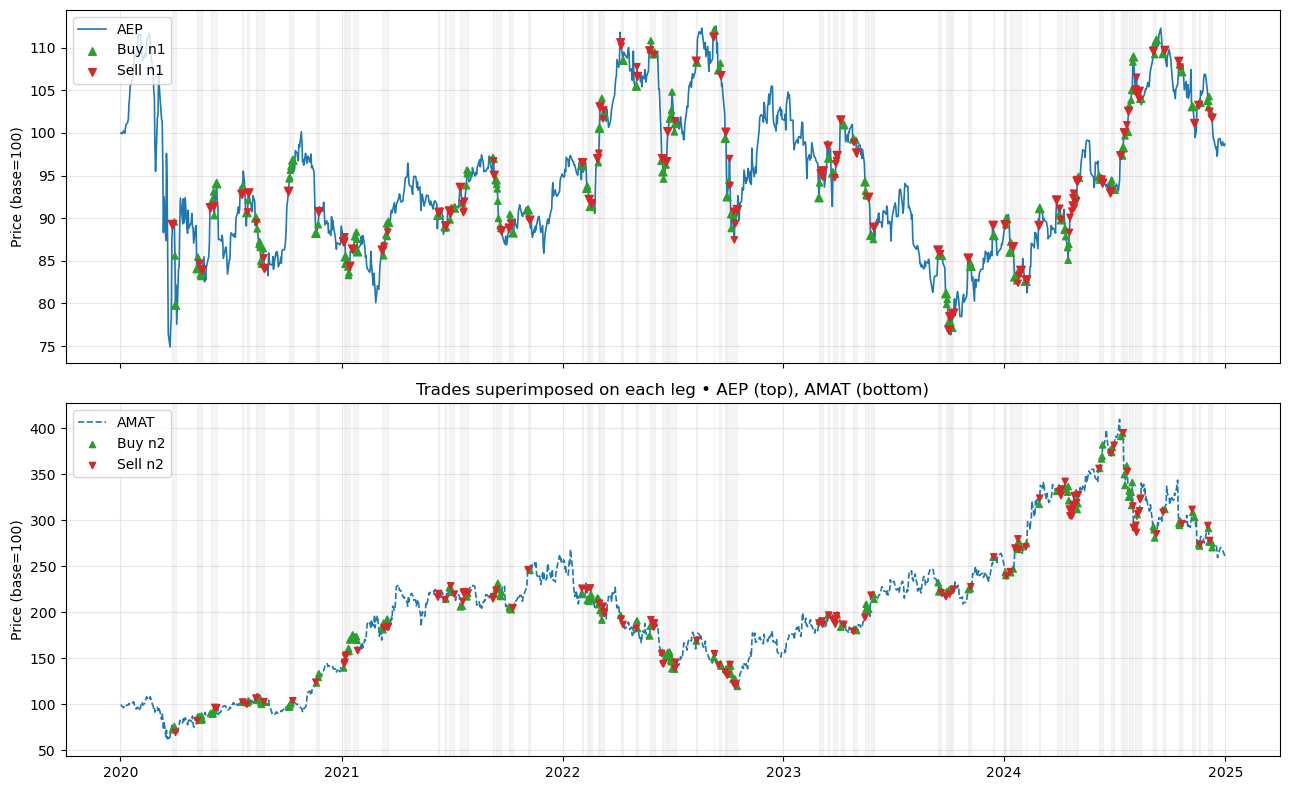

In [34]:
# df_pair: has P1,P2 columns (and optionally beta,y_hat)
# signals: from generate_pair_signals(...), has z,pos,n1,n2,entry,exit,stop

plot_pair_legs_with_trades(
    df_pair, signals,
    label1=ticker1, label2=ticker2,
    normalize=True, base_value=100,
    shade_positions=True,
    size_scale=0.004,   # tweak to taste based on your notional levels
    min_marker=20, max_marker=220
)


### Evaluate Performance of the Strategy

In [35]:
import numpy as np, pandas as pd

def evaluate_pair_signals(
    df_pair: pd.DataFrame,
    signals: pd.DataFrame,
    *,
    # cost model
    cost_bps: float = 0.0,            # commission+slippage, bps of traded notional (per leg)
    fee_per_share_1: float = 0.0,     # fixed fee per share for leg 1
    fee_per_share_2: float = 0.0,     # fixed fee per share for leg 2
    borrow_bps_per_year: float = 0.0, # short borrow (annual bps on short market value)
    days_per_year: int = 252,
    # return scaling
    capital_base: float | None = None # if None: median in-position gross exposure
):
    """
    Evaluate a single pair's executed signals (next-bar safe).
    Assumes signals has executed columns: ['pos','n1','n2'] (and optionally 'z','entry','exit','stop').

    Returns:
        daily  : DataFrame with pnl/returns/exposure/turnover
        trades : DataFrame of round-trip trades
        summary: dict of key metrics
    """
    # --- align & sanity ---
    cols = ["P1","P2"]
    df = pd.concat([df_pair[cols], signals], axis=1).copy()
    df = df.sort_index()
    # executed holdings
    n1 = df["n1"].astype(float).fillna(0.0)
    n2 = df["n2"].astype(float).fillna(0.0)
    pos = (np.sign(n1) != 0) | (np.sign(n2) != 0)

    # --- price changes (close-to-close PnL with *executed* holdings) ---
    dP1 = df["P1"].astype(float).diff().fillna(0.0)
    dP2 = df["P2"].astype(float).diff().fillna(0.0)
    pnl_gross = n1 * dP1 + n2 * dP2

    # --- trades and costs ---
    dn1 = n1.diff().fillna(n1)  # Δshares (entry/exit/rebalance on this bar)
    dn2 = n2.diff().fillna(n2)
    traded_notional = (dn1.abs() * df["P1"]) + (dn2.abs() * df["P2"])
    cost_comm_slip  = (cost_bps / 1e4) * traded_notional
    cost_per_share  = fee_per_share_1 * dn1.abs() + fee_per_share_2 * dn2.abs()

    short_notional = (np.where(n1 < 0, -n1 * df["P1"], 0.0)
                    + np.where(n2 < 0, -n2 * df["P2"], 0.0))
    cost_borrow = short_notional * (borrow_bps_per_year / 1e4) / days_per_year

    cost_total = cost_comm_slip + cost_per_share + cost_borrow
    pnl_net = pnl_gross - cost_total

    # --- exposures & returns ---
    gross_exposure = n1.abs() * df["P1"] + n2.abs() * df["P2"]
    net_exposure   = n1 * df["P1"] + n2 * df["P2"]

    if capital_base is None:
        # typical scale used during sizing; robust to outliers
        capital_base = float(np.nanmedian(gross_exposure.where(pos)))
        if not np.isfinite(capital_base) or capital_base <= 0:
            capital_base = 1.0

    ret_net = pnl_net / capital_base
    equity  = pnl_net.cumsum()

    # --- NEW: portfolio value & drawdowns on portfolio, not equity ---
    portfolio = capital_base + equity
    peak_port = portfolio.cummax()
    dd = portfolio - peak_port
    dd_pct = (portfolio / peak_port - 1.0).replace([-np.inf, np.inf], 0.0).fillna(0.0)
    # ----------------------------------------------------------------

    # --- turnover ---
    daily_turnover = traded_notional / capital_base

    daily = pd.DataFrame({
        "pnl_gross": pnl_gross,
        "cost": cost_total,
        "pnl_net": pnl_net,
        "ret_net": ret_net,
        "equity": equity,
        "portfolio": portfolio,        # NEW: convenient to inspect
        "gross_exposure": gross_exposure,
        "net_exposure": net_exposure,
        "turnover": daily_turnover,
        "in_pos": pos.astype(int),
        "drawdown": dd,                # moved here after portfolio calc
        "drawdown_pct": dd_pct,
    })

    # --- per-trade breakdown (round trips) ---
    entries = daily.index[(pos) & (~pos.shift(1, fill_value=False))]
    exits   = daily.index[(~pos) & (pos.shift(1, fill_value=False))]
    trade_rows = []
    for i, start in enumerate(entries):
        after = exits[exits > start]
        if len(after) == 0:
            break
        end = after[0]
        sl = daily.loc[start:end].iloc[:-1]  # exclude the flat bar at 'end'
        if sl.empty:
            continue
        side = int(np.sign(n1.loc[start]) or np.sign(n2.loc[start]))  # +1 long-spread, -1 short-spread
        pnl_g = sl["pnl_gross"].sum()
        cost  = sl["cost"].sum()
        pnl_n = sl["pnl_net"].sum()
        ret   = sl["ret_net"].sum()
        hold  = sl.shape[0]
        z_e   = df["z"].loc[start] if "z" in df else np.nan
        z_x   = df["z"].shift(1).loc[end] if "z" in df else np.nan  # decision z day before exit exec
        trade_rows.append({
            "entry": start, "exit": end, "side": side,
            "bars": hold, "pnl_gross": pnl_g, "cost": cost, "pnl_net": pnl_n, "ret_on_cap": ret,
            "z_at_entry": z_e, "z_prev_exit": z_x
        })
    trades = pd.DataFrame(trade_rows)
    if not trades.empty:
        wins = trades["pnl_net"] > 0
        profit_factor = (trades.loc[wins, "pnl_net"].sum() /
                         -trades.loc[~wins, "pnl_net"].sum()) if (~wins).any() else np.inf
        avg_hold = trades["bars"].mean()
        med_hold = trades["bars"].median()
        hitrate  = wins.mean()
        avg_win  = trades.loc[wins, "pnl_net"].mean() if wins.any() else 0.0
        avg_loss = trades.loc[~wins, "pnl_net"].mean() if (~wins).any() else 0.0
    else:
        profit_factor = np.nan; avg_hold = med_hold = hitrate = avg_win = avg_loss = np.nan

    # --- summary metrics ---
    n = daily.shape[0]
    ret_mean = daily["ret_net"].mean()
    ret_std  = daily["ret_net"].std(ddof=0)
    sharpe   = (ret_mean / ret_std) * np.sqrt(days_per_year) if ret_std > 0 else np.nan
    ann_ret  = (1.0 + daily["ret_net"].fillna(0)).prod() ** (days_per_year / max(n,1)) - 1.0
    ann_turnover = daily["turnover"].sum() * (days_per_year / max(n,1))
    mdd = float(-dd.min())                    # absolute drawdown (dollars)
    mdd_pct = float(-dd_pct.min())            # percentage drawdown on portfolio
    exposure_util = daily.loc[pos, "gross_exposure"].mean() / capital_base if pos.any() else 0.0

    summary = {
        "start": daily.index[0] if n else None,
        "end":   daily.index[-1] if n else None,
        "bars": n,
        "capital_base": capital_base,
        "gross_pnl": float(daily["pnl_gross"].sum()),
        "net_pnl": float(daily["pnl_net"].sum()),
        "ann_return": float(ann_ret),
        "sharpe": float(sharpe),
        "max_drawdown": mdd,
        "max_drawdown_pct": mdd_pct,
        "avg_gross_exposure": float(daily["gross_exposure"].mean()),
        "avg_exposure_utilization": float(exposure_util),
        "turnover_annualized": float(ann_turnover),
        "n_trades": int(len(trades)),
        "hit_rate": float(hitrate) if not np.isnan(hitrate) else np.nan,
        "avg_win": float(avg_win) if not np.isnan(avg_win) else np.nan,
        "avg_loss": float(avg_loss) if not np.isnan(avg_loss) else np.nan,
        "profit_factor": float(profit_factor) if np.isfinite(profit_factor) else np.inf,
        "avg_hold_bars": float(avg_hold) if not np.isnan(avg_hold) else np.nan,
        "med_hold_bars": float(med_hold) if not np.isnan(med_hold) else np.nan,
    }

    return daily, trades, summary


### Evaluate Performance on the training data

In [36]:
# df_pair has P1,P2; signals are your executed outputs (with next-bar logic)
daily, trades, summary = evaluate_pair_signals(
    df_pair, signals,
    cost_bps=1.0,                 # e.g., 1bp per side total (commission+slippage)
    fee_per_share_1=0.0, fee_per_share_2=0.0,
    borrow_bps_per_year=50.0,     # optional short borrow, e.g., 50 bps/year
    capital_base=10_000           # same as used when sizing n1/n2 (recommended)
)

print(pd.Series(summary))
# daily[['pnl_net','equity','drawdown_pct']].tail()
# trades.head()


start                       2020-01-02 00:00:00
end                         2024-12-31 00:00:00
bars                                       1258
capital_base                              10000
gross_pnl                          -2116.196273
net_pnl                            -2282.150578
ann_return                            -0.048357
sharpe                                -0.521328
max_drawdown                        2982.246231
max_drawdown_pct                       0.284874
avg_gross_exposure                  1956.661923
avg_exposure_utilization               1.000602
turnover_annualized                   28.445053
n_trades                                     69
hit_rate                               0.478261
avg_win                               126.42889
avg_loss                            -177.368658
profit_factor                          0.653403
avg_hold_bars                          3.565217
med_hold_bars                               3.0
dtype: object


### Evaluate Trained Strategy on (Fressh, Unseen) Test Data

In [37]:
start_test="2025-01-02"
end_test="2025-08-15"

In [38]:
df_test, failed = download_history_openbb([ticker1, ticker2], start_test, end_test, return_failed=True)

print(df_test.head())
if failed:
    print("No data for:", failed)


AMAT: 100%|██████████| 2/2 [00:00<00:00,  5.23it/s]

                        open       high        low      close   volume  \
ticker datetime                                                          
AEP    2025-01-02  92.570000  93.230003  91.589996  91.940002  1757200   
       2025-01-03  92.400002  93.059998  92.029999  92.050003  1688400   
       2025-01-06  92.050003  92.050003  90.010002  90.320000  3457200   
       2025-01-07  90.099998  91.910004  90.099998  90.470001  2706000   
       2025-01-08  90.250000  92.349998  89.910004  92.260002  2591500   

                   dividend  
ticker datetime              
AEP    2025-01-02       0.0  
       2025-01-03       0.0  
       2025-01-06       0.0  
       2025-01-07       0.0  
       2025-01-08       0.0  


In [39]:
"""
df_test = load_polygonio_lake(
    [ticker1, ticker2],
    start_test,
    end_test,
    path_polygonio_data,
    columns=["datetime","ticker","open","high","low","close","volume"],
    to_timezone="UTC",
    set_index=True, index_multi=True,
    debug=False
)
"""

'\ndf_test = load_polygonio_lake(\n    [ticker1, ticker2],\n    start_test,\n    end_test,\n    path_polygonio_data,\n    columns=["datetime","ticker","open","high","low","close","volume"],\n    to_timezone="UTC",\n    set_index=True, index_multi=True,\n    debug=False\n)\n'

In [40]:
df_test.head()

open       high        low      close   volume  \
ticker datetime                                                          
AEP    2025-01-02  92.570000  93.230003  91.589996  91.940002  1757200   
       2025-01-03  92.400002  93.059998  92.029999  92.050003  1688400   
       2025-01-06  92.050003  92.050003  90.010002  90.320000  3457200   
       2025-01-07  90.099998  91.910004  90.099998  90.470001  2706000   
       2025-01-08  90.250000  92.349998  89.910004  92.260002  2591500   

                   dividend  
ticker datetime              
AEP    2025-01-02       0.0  
       2025-01-03       0.0  
       2025-01-06       0.0  
       2025-01-07       0.0  
       2025-01-08       0.0

In [41]:
import numpy as np
import pandas as pd
from typing import Optional, Dict, Tuple, Any
from pykalman import KalmanFilter

def _align_two(series1: pd.Series, series2: pd.Series, name1="P1", name2="P2") -> pd.DataFrame:
    if not isinstance(series1.index, pd.DatetimeIndex):
        series1 = series1.copy(); series1.index = pd.to_datetime(series1.index, errors="coerce")
    if not isinstance(series2.index, pd.DatetimeIndex):
        series2 = series2.copy(); series2.index = pd.to_datetime(series2.index, errors="coerce")
    series1 = series1.sort_index()
    series2 = series2.sort_index()
    df = pd.concat([series1.rename(name1), series2.rename(name2)], axis=1, join="inner").dropna()
    return df.astype(np.float64)

def _coerce_last_state(
    last_state: Any,
    init_cov: float,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Accepts:
      - dict with keys 'mean' & 'cov' (or 'last_state_mean', 'last_state_cov')
      - tuple/list of (mean, cov)
      - np.ndarray of shape (2,) for mean (cov = init_cov*I)
      - np.ndarray of shape (2,2) for cov (mean = zeros)
      - None  -> (zeros, init_cov*I)
    Returns (mean(2,), cov(2,2)) as float64.
    """
    I = np.eye(2, dtype=np.float64)
    if last_state is None:
        return np.zeros(2, dtype=np.float64), I * float(init_cov)

    # dict
    if isinstance(last_state, dict):
        mean = last_state.get("mean", last_state.get("last_state_mean", None))
        cov  = last_state.get("cov",  last_state.get("last_state_cov",  None))
        if mean is None and cov is None:
            raise ValueError("last_state dict must contain 'mean' and/or 'cov'.")
        if mean is None:
            mean = np.zeros(2, dtype=np.float64)
        if cov is None:
            cov = I * float(init_cov)
        return np.asarray(mean, dtype=np.float64).reshape(2,), np.asarray(cov, dtype=np.float64).reshape(2,2)

    # tuple/list
    if isinstance(last_state, (tuple, list)):
        if len(last_state) != 2:
            raise ValueError("last_state tuple/list must be (mean, cov).")
        mean, cov = last_state
        if mean is None:
            mean = np.zeros(2, dtype=np.float64)
        if cov is None:
            cov = I * float(init_cov)
        return np.asarray(mean, dtype=np.float64).reshape(2,), np.asarray(cov, dtype=np.float64).reshape(2,2)

    # ndarray only
    arr = np.asarray(last_state)
    if arr.shape == (2,):
        return arr.astype(np.float64), I * float(init_cov)
    if arr.shape == (2, 2):
        return np.zeros(2, dtype=np.float64), arr.astype(np.float64)

    raise TypeError("Unsupported last_state type/shape.")

def filter_kf_on_new(
    P1_new: pd.Series,
    P2_new: pd.Series,
    *,
    frozen: Dict[str, np.ndarray],          # {"F":2x2, "Q":2x2, "R":1x1}
    last_state: Optional[Any] = None,       # dict | (mean,cov) | ndarray | None
    init_cov: float = 1e6,
    mode: str = "filter",                    # or "smooth"
) -> Tuple[pd.DataFrame, Dict[str, np.ndarray]]:
    # 1) Align
    df = _align_two(P1_new, P2_new, "P1", "P2")
    if len(df) < 5:
        raise ValueError("Not enough overlapping observations after alignment.")

    # 2) Inputs
    y = df["P1"].values.reshape(-1, 1)
    x = df["P2"].values
    n = len(df)

    H = np.zeros((n, 1, 2), dtype=np.float64)
    H[:, 0, 0] = x
    H[:, 0, 1] = 1.0

    F = np.asarray(frozen["F"], dtype=np.float64)
    Q = np.asarray(frozen["Q"], dtype=np.float64)
    R = np.asarray(frozen["R"], dtype=np.float64)

    init_mean, init_covm = _coerce_last_state(last_state, init_cov)

    # 3) Run KF
    kf = KalmanFilter(
        transition_matrices=F,
        observation_matrices=H,
        initial_state_mean=init_mean,
        initial_state_covariance=init_covm,
        transition_covariance=Q,
        observation_covariance=R,
    )

    if mode == "smooth":
        state_means, state_covs = kf.smooth(y)
        f_means, f_covs = kf.filter(y)  # to export filtered terminal state
        last_mean, last_cov = f_means[-1].copy(), f_covs[-1].copy()
    else:
        state_means, state_covs = kf.filter(y)
        last_mean, last_cov = state_means[-1].copy(), state_covs[-1].copy()

    beta_t  = state_means[:, 0]
    alpha_t = state_means[:, 1]
    y_hat   = alpha_t + beta_t * x
    resid   = df["P1"].values - y_hat

    out = pd.DataFrame(
        {"alpha": alpha_t, "beta": beta_t, "y_hat": y_hat, "resid": resid},
        index=df.index,
    )

    # Standardize the returned state format
    last_state_out = {"mean": last_mean, "cov": last_cov}
    return out, last_state_out


In [42]:
# pick the pair you trained
pair = (ticker1, ticker2)

# freeze hyperparameters learned on TRAIN
frozen = {
    "F": params_tr[pair]["F"],
    "Q": params_tr[pair]["Q"],
    "R": params_tr[pair]["R"],
}

# start the new run from the last *filtered* TRAIN state (or use None for diffuse)
last_state = (params_tr[pair]["last_state_mean"], params_tr[pair]["last_state_cov"])

# make sure P1_new, P2_new are aligned and share the same DateTimeIndex
P1_new = df_test.loc[(ticker1,), 'close']
P2_new = df_test.loc[(ticker2,), 'close']

df_new_states, last_state = filter_kf_on_new(
    P1_new, P2_new,
    frozen=frozen,
    last_state=last_state,   # or None if this is a disjoint start
    init_cov=1e6,
    mode="filter",
)

# df_new_states has ['alpha','beta','y_hat','resid'] for the new period


In [43]:
df_new_states.head()

,alpha,beta,y_hat,resid
datetime,,,,
2025-01-02,72.948525,0.117144,92.144854,-0.204851
2025-01-03,72.949704,0.113617,92.271448,-0.221445
2025-01-06,72.954510,0.101560,90.979453,-0.659454
2025-01-07,72.954741,0.099225,90.598954,-0.128952
2025-01-08,72.954912,0.106720,91.843372,0.416630


In [44]:
df_pair_test = pd.DataFrame({
    'P1': P1_new,
    'P2': P2_new
}).join(df_new_states[['beta', 'resid']])

In [45]:
signals_test = generate_pair_signals(
    df_pair_test,
    z_method="robust",
    z_entry=2.0, z_exit=0.5, z_stop=4.0,
    capital_per_pair=10_000,
    max_hold_bars=None,            # set like 3*estimate_halflife(df_pair['resid'])
    cooldown_bars=0
)

(<Figure size 1300x800 with 2 Axes>,
 (<Axes: ylabel='Price (base=100)'>,
  <Axes: title={'center': 'Trades superimposed on each leg • AEP (top), AMAT (bottom)'}, ylabel='Price (base=100)'>))

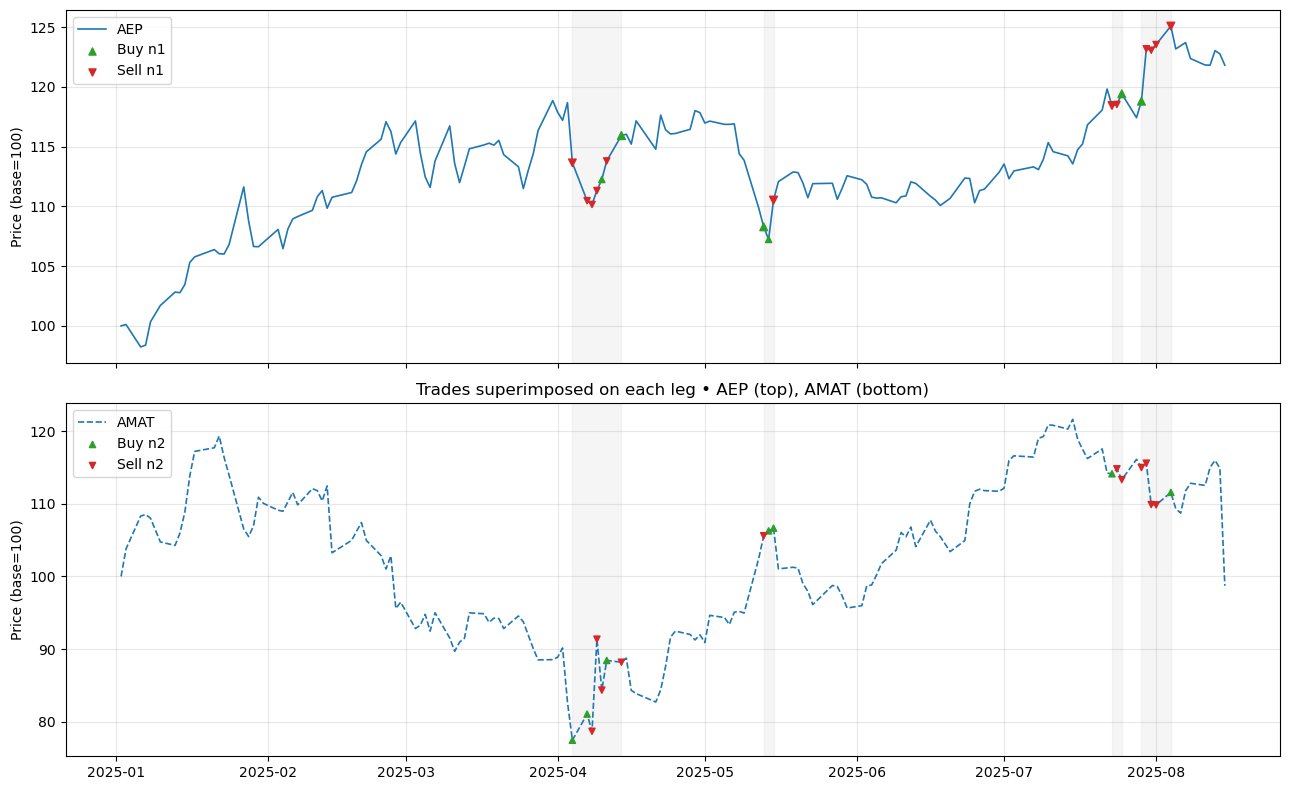

In [46]:
# df_pair: has P1,P2 columns (and optionally beta,y_hat)
# signals: from generate_pair_signals(...), has z,pos,n1,n2,entry,exit,stop

plot_pair_legs_with_trades(
    df_pair_test, signals_test,
    label1=ticker1, label2=ticker2,
    normalize=True, base_value=100,
    shade_positions=True,
    size_scale=0.004,   # tweak to taste based on your notional levels
    min_marker=20, max_marker=220
)


In [47]:
# df_pair has P1,P2; signals are your executed outputs (with next-bar logic)
daily_test, trades_test, summary_test = evaluate_pair_signals(
    df_pair_test, signals_test,
    cost_bps=1.0,                 # e.g., 1bp per side total (commission+slippage)
    fee_per_share_1=0.0, fee_per_share_2=0.0,
    borrow_bps_per_year=50.0,     # optional short borrow, e.g., 50 bps/year
    capital_base=10_000           # same as used when sizing n1/n2 (recommended)
)

print(pd.Series(summary_test))
# daily[['pnl_net','equity','drawdown_pct']].tail()
# trades.head()

start                       2025-01-02 00:00:00
end                         2025-08-15 00:00:00
bars                                        155
capital_base                              10000
gross_pnl                            832.060293
net_pnl                              822.269943
ann_return                             0.139263
sharpe                                  1.64571
max_drawdown                         511.003033
max_drawdown_pct                       0.047683
avg_gross_exposure                   902.898024
avg_exposure_utilization               0.999637
turnover_annualized                   13.486205
n_trades                                      4
hit_rate                                   0.75
avg_win                              365.051142
avg_loss                            -268.808991
profit_factor                          4.074095
avg_hold_bars                               3.5
med_hold_bars                               3.0
dtype: object
